# (a)

Derive coordinate descent for $l_1$ regularization.

\begin{align*} 
J(\theta)
&= \frac{1}{2}\left|\left|X \theta - y\right|\right|_2^2  + \lambda \left|\left|\theta \right|\right|_1 \\
&= \frac{1}{2}\left|\left|X \bar \theta + X_i \theta_i - y\right|\right|_2^2  + \lambda \left|\left|\bar \theta \right|\right|_1 + \lambda \left|\left|\theta_i \right|\right|_1 \\
&= \frac{1}{2}(X \bar \theta + X_i \theta_i - y)^T(X \bar \theta + X_i \theta_i - y) + \lambda \left|\left|\bar \theta \right|\right|_1 + \lambda \left|\left|\theta_i \right|\right|_1 \\
&= \frac{1}{2}(\theta_i X_i^T X \bar \theta + \theta_i^2 X_i^T X_i - \theta_i X_i^T y + \bar \theta^T X^T X_i \theta_i - y^T X_i \theta_i + C) + \lambda \left|\left|\bar \theta \right|\right|_1 + \lambda \left|\left|\theta_i \right|\right|_1 \\
&= \frac{1}{2}(\theta_i X_i^T X \bar \theta + \theta_i^2 X_i^T X_i - \theta_i X_i^T y + \bar \theta^T X^T X_i \theta_i - y^T X_i \theta_i + C) + \lambda \left|\left|\bar \theta \right|\right|_1 + \lambda s_i\theta_i
\end{align*}

where $s_i \in \{-1, 1\}$.

A note on the shapes of the matrices:

* $X$: $m \times n$, $m$ samples, $n$ features
* $\theta$: $n \times 1$
* $X_i$: $m \times 1$
* $\theta_i$: a scalar

The above single out $\theta_i$ where coordinate ascent will be applied. We put the terms that are independent of $\theta_i$ all together into $C$, and they'll dispear when taking gradient of $J(\theta)$.

First, consider the case when $s_i = 1$,

\begin{align*}
\frac{\partial J(\theta)}{\partial \theta_i} 
&= \frac{1}{2}(X_i^T X \bar \theta + 2\theta_i X_i^TX_i - X_i^Ty +  \bar \theta^T X^T X_i - y^TX_i) + \lambda \\
&= X_i^T X \bar \theta + \theta_i X_i^TX_i - X_i^Ty + \lambda
\end{align*}

Setting derivative to zero,

\begin{align*}
\theta_i = - \frac{X_i^T (X \bar \theta - y) + \lambda}{X_i^T X_i}
\end{align*}

For those good at linear algebra, it could be obvious even without spaning the matrix product.

Similarly, when $s_i = -1$,

\begin{align*}
\frac{\partial J(\theta)}{\partial \theta_i}  = X_i^T X \bar \theta + \theta_i X_i^TX_i - X_i^Ty - \lambda
\end{align*}

Similarly, setting derivative to zero,

\begin{align*}
\theta_i = - \frac{X_i^T (X \bar \theta - y) - \lambda}{X_i^T X_i}
\end{align*}

# (b-c) implement l1 regularization with coordinate descent, then test my implementation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('./q3_solution/x.dat', sep=r'\s+', header=None)

df.shape

y = pd.read_csv('./q3_solution/y.dat', sep=r'\s+', header=None)

true_theta = pd.read_csv('./q3_solution/theta.dat', sep=r'\s+', header=None)

In [3]:
def cost(X, y, theta, lamb):
    diff = np.dot(X, theta) - y
    return 0.5 * np.dot(diff.T, diff) + lamb * np.abs(theta).sum()


def l1ls(X, y, lamb, delta_cutoff=1e-5):
    """delta: convergence cutoff"""
    num_features = X.shape[1]
    theta = np.random.random(X.shape[1])
    max_delta = 0
    count = 0
    deltas = []
    costs = []
    while True:
        i = count % num_features
        
        theta_bar = np.concatenate([theta[:i], [0], theta[i+1:]])
        X_i = X[:,i]
        common_part = X_i.dot(X.dot(theta_bar) - y)

        # when s_i = 1
        theta1 = theta.copy()
        ## TOOK QUITE SOME TIME TO FIGURE OUR THE MINUX SIGN IS IGNORE!!!
        theta1[i] = np.max([- (common_part + lamb) / X_i.dot(X_i), 0])
        cost1 = cost(X, y, theta1, lamb)

        # when s_i = -1
        theta2 = theta.copy()
        theta2[i] = np.min([- (common_part - lamb) / X_i.dot(X_i), 0])
        cost2 = cost(X, y, theta2, lamb)
        
        if cost1 < cost2:
            new_theta = theta1
            costs.append(cost1)
        else:
            new_theta = theta2
            costs.append(cost2)
        
        delta = np.abs(new_theta[i] - theta[i]).sum()
        if delta > max_delta:
            max_delta = delta
        deltas.append(delta)
        
        if i == num_features - 1:
            if max_delta < delta_cutoff:
                print('converged after {0} steps'.format(count + 1))
                return theta, deltas, costs
            else:
                max_delta = 0 # reset max_delta
        
        theta = new_theta
        count += 1
        
        if count == 5000: # set a deadline for debugging purpose, it shouldn't take that many steps
            print(count)
            return theta, deltas, costs

converged after 3100 steps
converged after 3100 steps
converged after 3400 steps


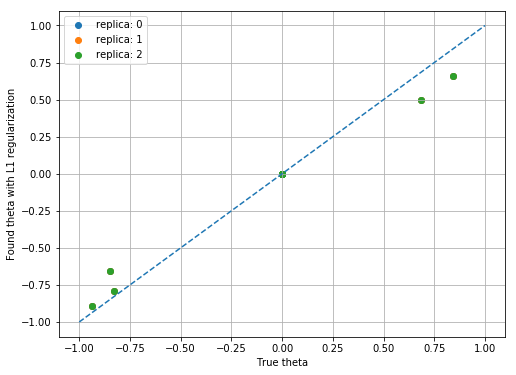

In [5]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot([-1, 1], [-1, 1], '--')

for i in range(3):
    th, deltas, costs = l1ls(df.values, y.values.ravel(), lamb=1)
    ax.scatter(true_theta, th, label='replica: {0}'.format(i))
ax.set_xlabel('True theta')
ax.set_ylabel('Found theta with L1 regularization')
ax.grid()
ax.legend()

This shows that there is probably a single global optimum since the optimizations always converge to the same points.

### Try different $\lambda$ values

5000
5000
5000
converged after 3400 steps
converged after 1200 steps


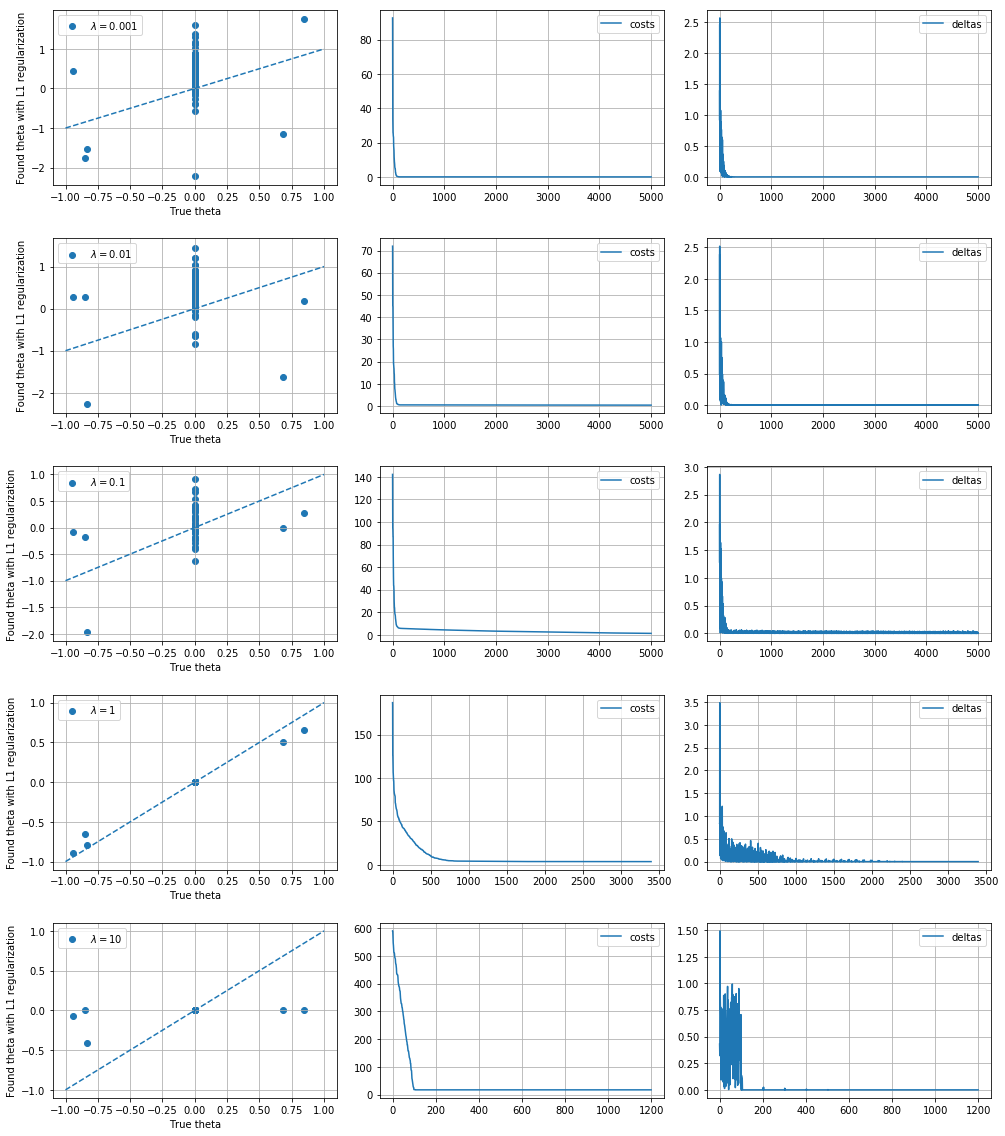

In [6]:
fig, axes = plt.subplots(5, 3, sharex=False, sharey=False, figsize=(14, 16))
axes = axes.ravel()

for k, lamb in enumerate([0.001, 0.01, 0.1, 1, 10]):
    th, deltas, costs = l1ls(df.values, y.values.ravel(), lamb=lamb)
    
    ax = axes[k * 3]
    ax.plot([-1, 1], [-1, 1], '--')
    ax.scatter(true_theta, th, label='$\lambda = {0}$'.format(lamb))
    ax.set_xlabel('True theta')
    ax.set_ylabel('Found theta with L1 regularization')
    ax.legend(loc='upper left')

    axes[k * 3 + 1].plot(costs, label='costs')
    axes[k * 3 + 1].legend()
    
    axes[k * 3 + 2].plot(deltas, label='deltas')
    axes[k * 3 + 2].legend()
    
for _ in axes:
    _.grid()
plt.tight_layout()

So $\lambda = 1$ seems to be of the proper regularization strength. Also, stronger regularization decreases the number of features with non-zero coefficient.